# EMO task

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Dependencies

In [2]:
!pip install transformers
!pip install accelerate -U
!pip install datasets
!pip install torch-summary
!pip install graphviz
!pip install torchview
!pip install bertviz
#-q
repo_path = "https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/"
branch = "ire"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.9/135.9 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [116]:
utils_url = f"{repo_path}{branch}/utils.py"
evaluation_url = f"{repo_path}{branch}/evaluation.py"

import os
if os.path.exists("utils.py"):
  !rm "utils.py"
if os.path.exists("evaluation.py"):
  !rm "evaluation.py"

!wget {utils_url}
!wget {evaluation_url}

--2023-06-28 10:14:29--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/ire/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14112 (14K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]  13.78K  --.-KB/s    in 0s      

2023-06-28 10:14:29 (43.4 MB/s) - ‘utils.py’ saved [14112/14112]

--2023-06-28 10:14:29--  https://raw.githubusercontent.com/HLT-Ghisolfi-Leuzzi-Testa/WASSA-2023/ire/evaluation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10675 (10K) [text/plai

In [117]:
import json
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, TrainerCallback, EarlyStoppingCallback
import importlib
import sys
from utils import *
importlib.reload(sys.modules['utils'])

<module 'utils' from '/content/utils.py'>

In [9]:
# set CUDA if available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("======= CUDA Available =======")
else:
    device = torch.device('cpu')
    print("======= CUDA NOT Available, run on CPU =======")
device = torch.device('cpu')

======= CUDA Available =======


## Model

In [16]:
models={
  'distilroberta-emotion':'j-hartmann/emotion-english-distilroberta-base',
  'roberta-emotion':'j-hartmann/emotion-english-roberta-large',
  'berta-base':'bert-base-cased'
}

In [99]:
NUM_LABELS = 8

model_config = {
    'model_id': 'bert_baseline',
    'tokenizer_name': models.get('distilroberta-emotion'),
    'model_name': models.get('distilroberta-emotion'),
    'train_batch_size': 4,
    'val_batch_size': 4,
    'learning_rate': 5e-5,
    'weight_decay': 0,
    'epochs': 5,
    'seed': 42,
    'patience': 3,
    'early_stopping_threshold': 0
} # TODO: expand...

In [31]:
tokenizer = AutoTokenizer.from_pretrained(model_config['tokenizer_name'], truncation=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_config['model_name'],
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")

model.to(device)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at j-hartmann/emotion-english-distilroberta-base and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([8]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

## Dataset

Dataset paths

In [32]:
TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_train_preproc.tsv"
VAL_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_val_preproc.tsv"
FULL_TRAIN_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_full_train_preproc.tsv"

DEV_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_dev_preproc.tsv"

TEST_DATA = f"{repo_path}{branch}/datasets/WASSA23_essay_level_test_preproc.tsv"

Optional subsample

In [ ]:
train_df = train_df[:20]
val_df = val_df[:10]
dev_df = dev_df[:10]

Read dataframes

In [85]:
from sklearn.model_selection import train_test_split

In [113]:
train_df = pd.read_csv(TRAIN_DATA, sep='\t') # train
val_df = pd.read_csv(VAL_DATA, sep='\t') # internal validation
full_train_df = pd.read_csv(FULL_TRAIN_DATA, sep='\t') # train + internal val

dev_df = pd.read_csv(DEV_DATA, sep='\t') # validation

full_dev_df = pd.concat([full_train_df, dev_df], ignore_index = True)

test_df = pd.read_csv(TEST_DATA, sep='\t') # test

In [ ]:
full_dev_df

Encode targets

In [88]:
label_encoder = EmotionsLabelEncoder()
label_encoder.fit(train_df.emotion)

In [89]:
y_train = label_encoder.encode(train_df.emotion)
y_val = label_encoder.encode(val_df.emotion)

y_full_train = label_encoder.encode(full_train_df.emotion)

y_dev = label_encoder.encode(dev_df.emotion)

y_full_dev = label_encoder.encode(full_dev_df.emotion)

Prepare datasets

In [118]:
train_set = EMODataset(tokenizer=tokenizer, essay=train_df.essay, targets=y_train)
val_set = EMODataset(tokenizer=tokenizer, essay=val_df.essay, targets=y_val)
full_train_set = EMODataset(tokenizer=tokenizer, essay=full_train_df.essay, targets=y_full_train)

dev_set = EMODataset(tokenizer=tokenizer, essay=dev_df.essay, targets=y_dev)

full_dev_set = EMODataset(tokenizer=tokenizer, essay=full_dev_df.essay, targets=y_full_dev)

test_set = EMODataset(tokenizer=tokenizer, essay=test_df.essay, targets=None)

## Training

Set up training

In [104]:
train_arguments = TrainingArguments(
    output_dir=f"./{model_config['model_name']}",
    per_device_train_batch_size=model_config['train_batch_size'],
    #per_device_eval_batch_size=model_config['val_batch_size'],
    num_train_epochs=model_config['epochs'],
    evaluation_strategy="no",
    save_strategy="epoch",
    learning_rate=model_config['learning_rate'],
    weight_decay=model_config['weight_decay'],
    load_best_model_at_end=False,
    #metric_for_best_model='eval_loss',
    seed=model_config['seed'],
    logging_strategy = "epoch"
) # TODO: custom other params

trainer = Trainer(
    model=model,
    args=train_arguments,
    train_dataset=full_dev_set,
    #eval_dataset=None,
    tokenizer=tokenizer,
    #compute_metrics=compute_EMO_metrics_trainer
)

Callbacks

In [83]:
class TrainerLoggingCallback(TrainerCallback):
    def __init__(self, log_path):
        self.log_path = log_path

    def on_log(self, args, state, control, logs=None, **kwargs):
        _ = logs.pop("total_flos", None)
        if state.is_local_process_zero: # whether this process is the main one in a distributed setting
            with open(self.log_path, "a") as f:
                f.write(json.dumps(logs) + "\n")

trainer.add_callback(EarlyStoppingCallback(
    early_stopping_patience=model_config['patience'],
    early_stopping_threshold=model_config['early_stopping_threshold']))
trainer.add_callback(TrainerLoggingCallback(model_config['model_id']+"_log.json"))

Start training

In [105]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,0.043000
200,0.046300
300,0.047600
400,0.038500
500,0.038900
600,0.024100
700,0.017600
800,0.016200
900,0.005400
1000,0.006800


TrainOutput(global_step=1250, training_loss=0.02398495705127716, metrics={'train_runtime': 284.6959, 'train_samples_per_second': 17.563, 'train_steps_per_second': 4.391, 'total_flos': 662407864320000.0, 'train_loss': 0.02398495705127716, 'epoch': 5.0})

In [106]:
# Access the training logs
train_logs = trainer.state.log_history

# Extract the loss values from the logs
train_loss_values = [log.get('loss') for log in train_logs if log.get('loss') is not None]
eval_loss_values = [log.get('eval_loss') for log in train_logs if log.get('eval_loss') is not None]

In [ ]:
train_loss_values

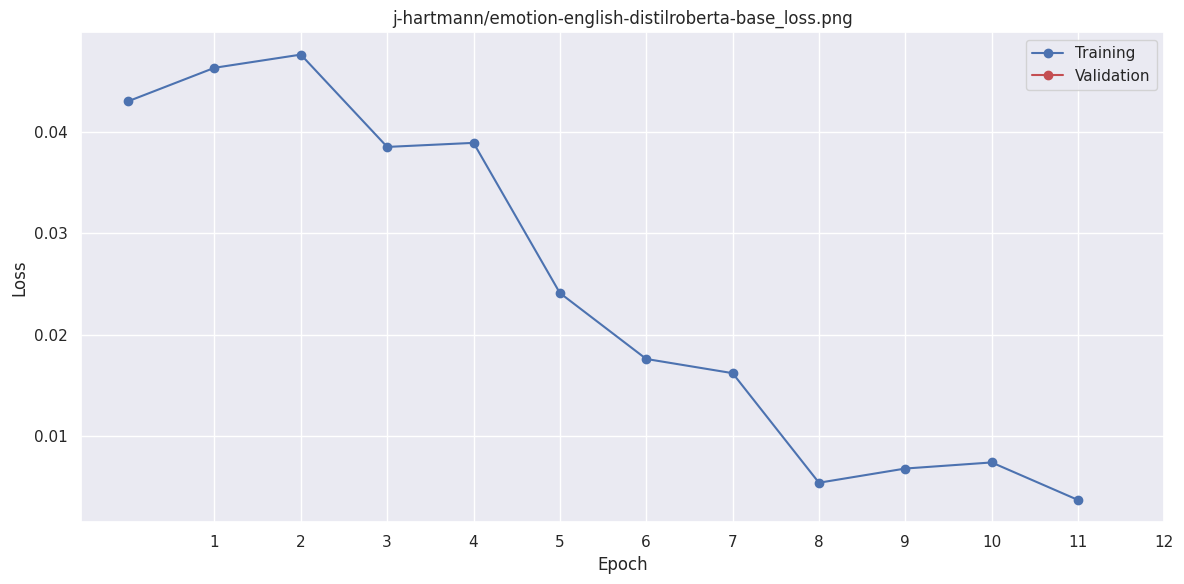

In [107]:
plot_loss_curve(train_loss_values, eval_loss_values, "loss", f"{model_config['model_name']}_loss.png")

## Evaluation

In [130]:
trainer.state.best_model_checkpoint

In [119]:
results = trainer.predict(test_set)

In [ ]:
label_encoder.decode(np.where(results.predictions >= 0.5, 1, 0))

In [124]:
#gold_emotions = label_encoder.decode(results.label_ids)
binarized_predictions = np.where(results.predictions >= 0.5, 1, 0)
for i, bin_pred in enumerate(binarized_predictions):
  if np.all(bin_pred==0):
    binarized_predictions[i][np.argmax(results.predictions[i])] = 1
    # alternatively set the 'Neutral' emotion (cannot do it in compute_EMO_metrics_trainer)
    # binarized_predictions[i] = label_encoder.encode(['Neutral'])[0]
predicted_emotions = label_encoder.decode(binarized_predictions)

In [ ]:
pd.DataFrame(test_set.essay)

In [ ]:
predicted_emotions

In [129]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")

In [ ]:
write_EMO_predictions(predicted_emotions, model_config['model_id']+"_predictions_EMO.tsv")
challenge_metrics = compute_EMO_metrics(golds=gold_emotions, predictions=predicted_emotions)
write_dict_to_json(challenge_metrics, model_config['model_id']+"_dev_metrics.json")
challenge_metrics

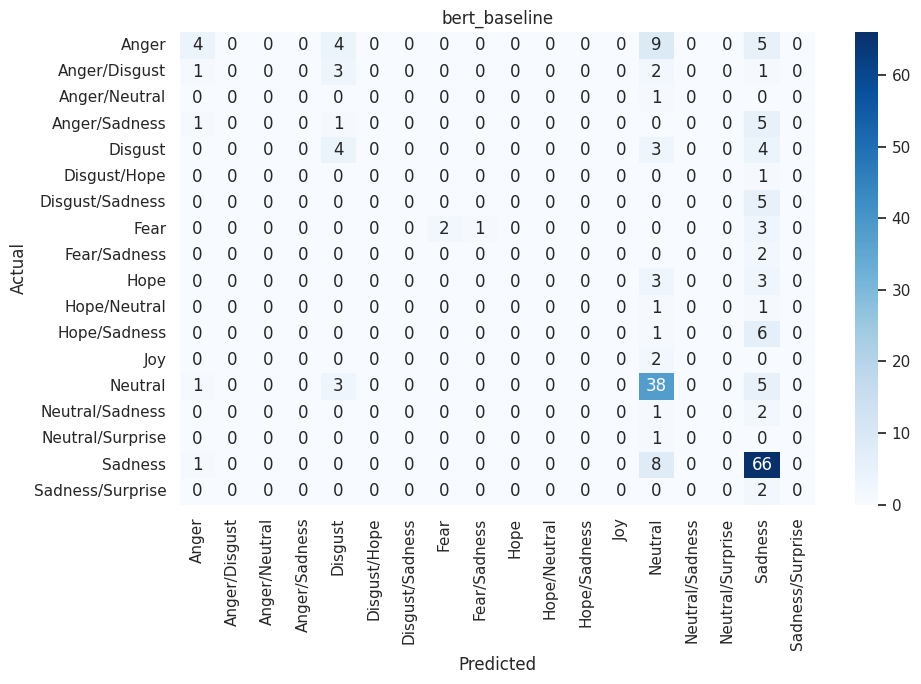

In [ ]:
plot_confusion_matrix(golds=gold_emotions, predictions=predicted_emotions, path=model_config['model_id']+"_confusion_matrix.pdf", title=model_config['model_id'])

In [ ]:
plot_model_graph(model=model, input_data=tokenizer("Hello world!", return_tensors="pt"), path=model_config['model_id']+"_graph")

In [ ]:
print_model_summary(model=model, path=model_config['model_id']+"_summary.txt")

Layer (type:depth-idx)                   Param #
├─BertModel: 1-1                         --
|    └─BertEmbeddings: 2-1               --
|    |    └─Embedding: 3-1               22,268,928
|    |    └─Embedding: 3-2               393,216
|    |    └─Embedding: 3-3               1,536
|    |    └─LayerNorm: 3-4               1,536
|    |    └─Dropout: 3-5                 --
|    └─BertEncoder: 2-2                  --
|    |    └─ModuleList: 3-6              85,054,464
|    └─BertPooler: 2-3                   --
|    |    └─Linear: 3-7                  590,592
|    |    └─Tanh: 3-8                    --
├─Dropout: 1-2                           --
├─Linear: 1-3                            6,152
Total params: 108,316,424
Trainable params: 108,316,424
Non-trainable params: 0


## Save model on Google Drive

In [132]:
trainer.state.best_model_checkpoint

In [133]:
!mv /content/j-hartmann/emotion-english-distilroberta-base/checkpoint-1250 /content/drive/MyDrive/hlt

## Inference

In [ ]:
MODEL_PATH = "/content/drive/MyDrive/hlt/best-roberta"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, truncation=True)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    num_labels=NUM_LABELS,
    ignore_mismatched_sizes=True,
    problem_type="multi_label_classification")